# Environment setup and libray inclusion

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab/AN2DL/Homework2

Mounted at /gdrive
/gdrive/MyDrive/Colab/AN2DL/Homework2


In [2]:
# Inclusing libraries
from google.colab                           import files, runtime

from matplotlib.colors                      import ListedColormap
from tensorflow                             import keras as tfk
from tensorflow.keras                       import layers as tfkl
from tensorflow.keras.applications          import ConvNeXtBase
from tensorflow.keras.models                import Model, load_model
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from sklearn.metrics                        import accuracy_score, precision_score,\
                                                    recall_score, f1_score,\
                                                    confusion_matrix
from sklearn.model_selection                import train_test_split
from sklearn.utils                          import class_weight

import matplotlib.pyplot                    as plt
import numpy                                as np
import os
import pandas                               as pd
import seaborn                              as sns
import tensorflow                           as tf

We define a series of useful functions which will be called throught the notebook.

In [3]:
def y_to_df(y) -> pd.DataFrame:
    """
    Function in charge of exporting segmentation predictions into a DataFrame
    format for Kaggle.

    -------
    y: segmentation predictions
    """
    n_samples   = len(y)
    y_flat      = y.reshape(n_samples, -1)
    df          = pd.DataFrame(y_flat)
    df["id"]    = np.arange(n_samples)
    cols        = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]


def displayImage(image, title="") -> None:
    """
    Function in charge of displaying an image

    -------
    image: image to be displayed
    title: title of the image
    """

    plt.imshow(image, cmap="grey")
    plt.title(title)
    plt.show()


def displaySegmentedImage(image_with_segmentation, title="Original Image") -> None:
    """
    Function in charge of displaying a segmented image

    -------
    image_with_segmentation: image to be displayed (NOT one-hot-encoded)
    title: title of the image
    """

    if image_with_segmentation.shape[0] != 2:
        raise ValueError("Input array must have two components along axis 0 (image and segmentation).")

    # Extract image and segmentation
    image   = image_with_segmentation[0]  # Original image
    seg     = image_with_segmentation[1]  # Segmentation classes

    # Define a colormap for segmentation classes
    colours = ['black', 'brown', 'blue', 'yellow', 'grey']
    cmap    = []
    for label in range(5):
        if np.any(seg == label):
            cmap.append(colours[label])
    cmap    = ListedColormap(cmap)

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(title)
    axes[0].axis("off")

    # Overlay segmentation on top of the original image
    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(seg, cmap=cmap, alpha=0.5)  # Alpha for transparency
    axes[1].set_title("Segmented Image")
    axes[1].axis("off")

    # Add colour legend
    legend_elements = ["background", "soil", "bedrock", "sand", "big rock"]
    legend_handles  = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colours[i], markersize=10) for i in range(5)]
    axes[0].legend(legend_handles, legend_elements, title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()


def goodnight() -> None:
    """
    Function in charge of disconnecting current runtime
    """
    runtime.unassign()

# Load model and test set

We load the latest trained model and test sets so that we can make predictions.

In [4]:
class LayerWiseAverage(tfkl.Layer):
    def call(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

class LayerWiseMax(tfkl.Layer):
    def call(self, x):
        return tf.reduce_max(x, axis=-1, keepdims=True)


custom_objects = {
    "LayerWiseAverage": LayerWiseAverage,
    "LayerWiseMax": LayerWiseMax,
}

model_name: str = "RosaNet-Mark6.5.10"
model = tfk.models.load_model(f"{model_name}.keras", compile=False, custom_objects=custom_objects)

In [5]:
dataset     = np.load("mars.npz")
test_images = dataset["test_set"]

# Make predictions

We make segmentation predictions on the test set using the imported model and test samples. We can also view some of the performed segmentations if desired.

314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step
Predictions shape: (10022, 64, 128)


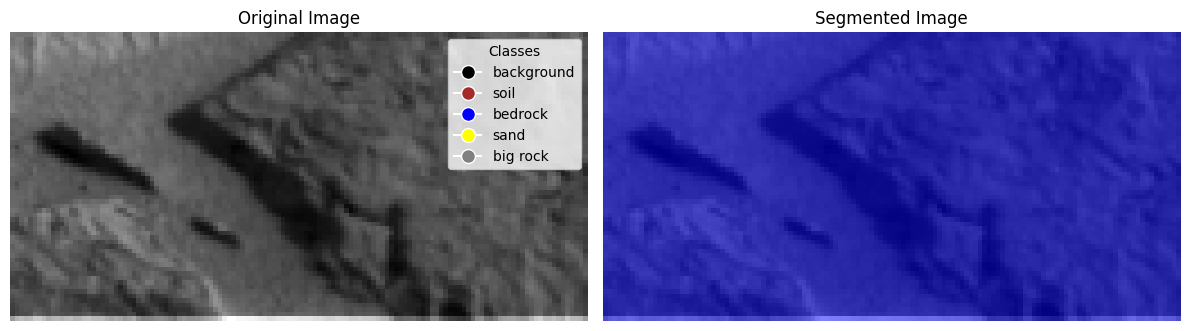

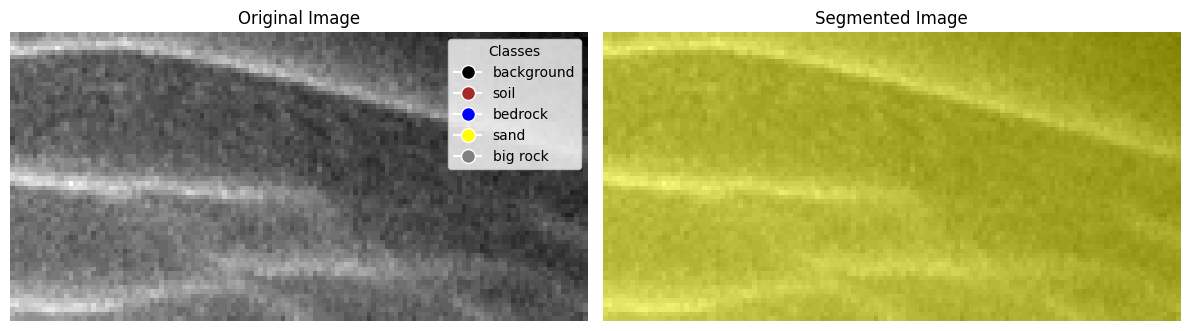

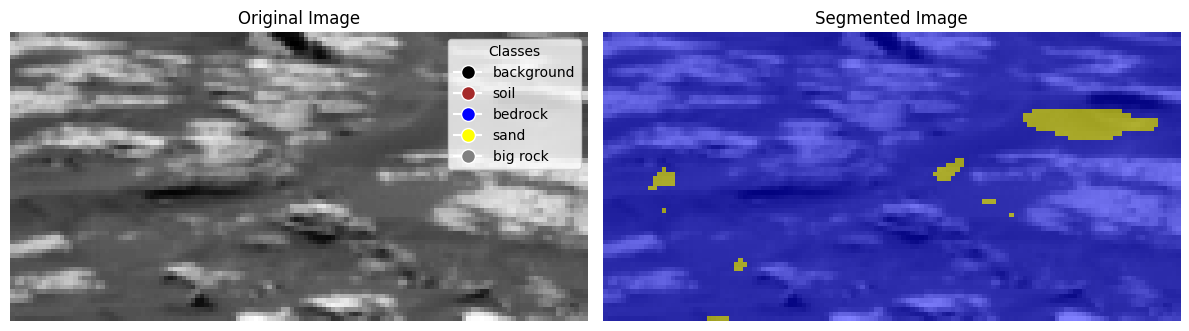

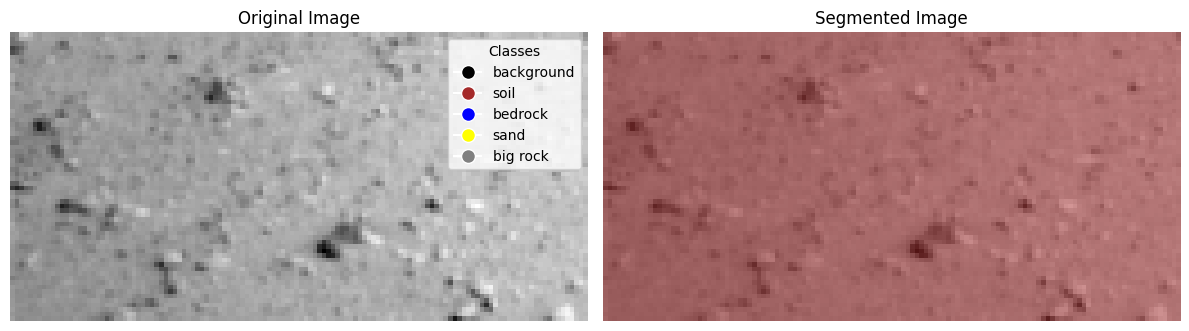

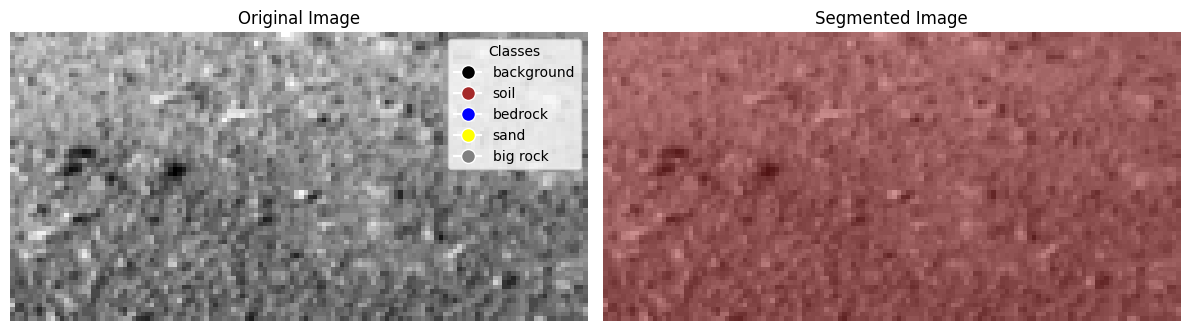

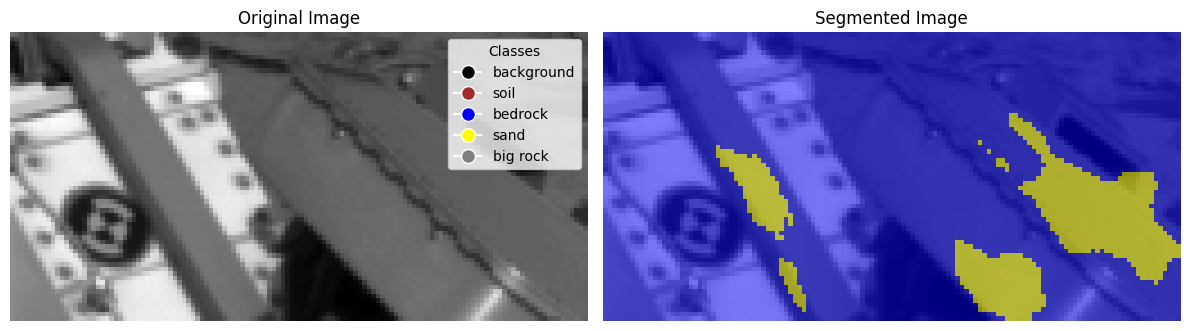

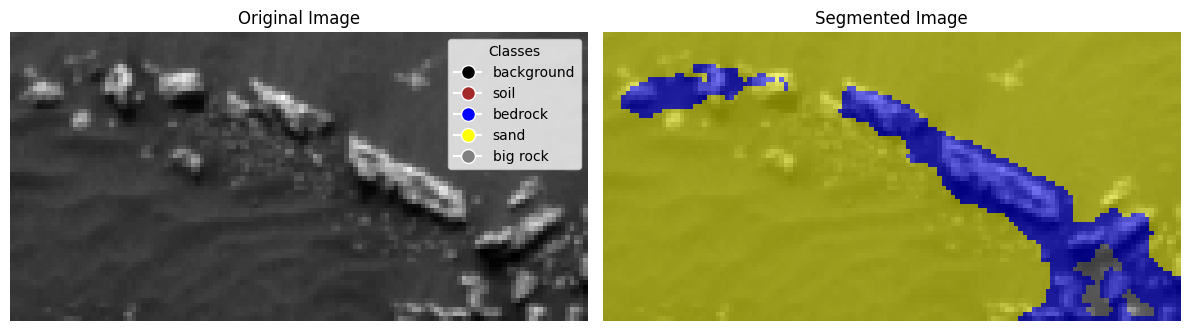

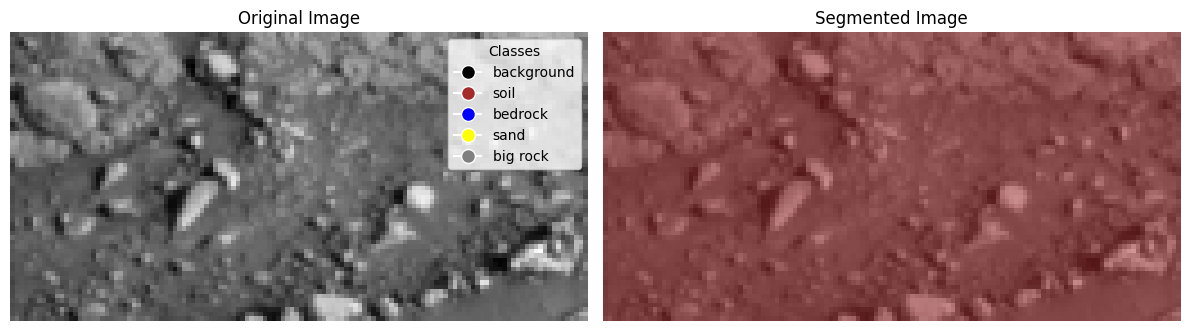

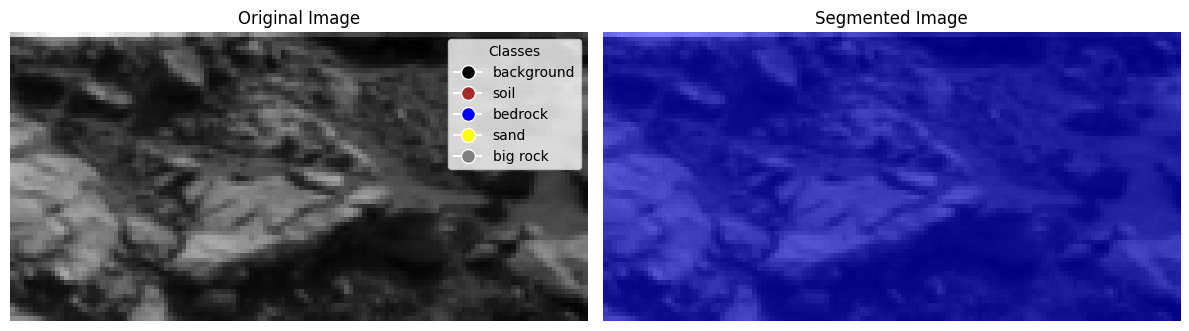

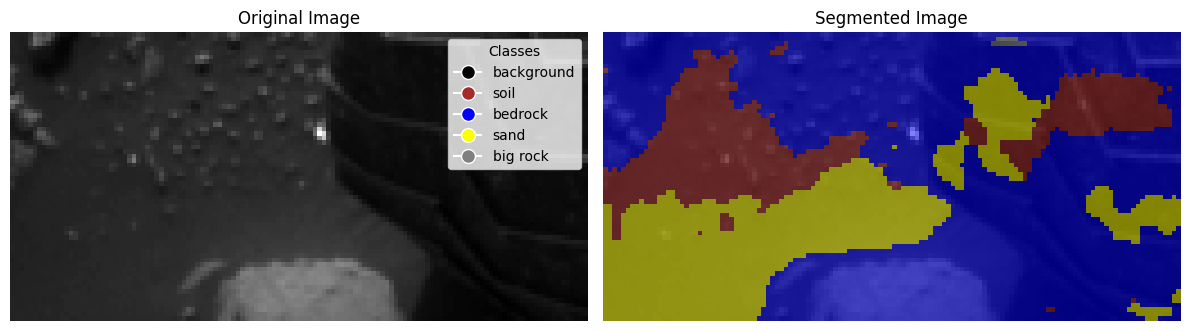

In [6]:
preds = model.predict(test_images / 255.0)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

# View performed segmentations
for i in range(10):
    displaySegmentedImage(np.array([test_images[i], preds[i]]))

Finally, we export the performed predictions to pandas dataframe stored in a CSV file which can be readily uploaded to Kaggle for evaluation.

In [7]:
# Create and download the csv submission file
submission_filename = f"submission_{model_name}.csv"
submission_df       = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)


# Download the constructed file
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Disconnecting **[DISABLED]**

Disconnect runtime to avoid consuming resources if the notebook has completed its execution.

In [8]:
# Disabled since CSV download occurs in background and disconnecting would kill the process
#goodnight()